In [61]:
from IPython.display import Image, display
import pandas as pd
import json
from dotenv import load_dotenv
import time
import yfinance as yf

from fuzzywuzzy import process

from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage
from langchain_core.messages import RemoveMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig

from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langgraph.graph.message import REMOVE_ALL_MESSAGES
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Literal, Optional, Dict, Union
from typing_extensions import Annotated
from operator import add

In [62]:
# Load env variables from .env.example
load_dotenv("../.env")

True

In [63]:
# Constants
FUZZY_LIMIT = 5
LOW_CONFIDENCE_THRESHOLD = 50  # Minimum score to consider
HIGH_CONFIDENCE_THRESHOLD = 90  # If score ≥ 90, skip LLM

In [64]:
# initialize model for large number of input tokens
llmg = init_chat_model("gemini-2.0-flash", model_provider="google_genai")
# Initialize the LLM
llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

In [65]:
# Load CSV of NSE companies
df = pd.read_csv("../data/EQUITY_L.csv")  # Assumes columns: "Company Name", "Symbol"
company_names = df["NAME OF COMPANY"].tolist()

In [66]:
prompt_stock_query_check = ChatPromptTemplate.from_template(
    "Classify the last user message into one of these categories:\n"
    "Always give single response as simple string. \n"
    "- 'greeting': casual greeting like hello, hi, good morning.\n"
    "- 'non_stock': general query unrelated to stocks.\n"
    "- 'multi_stock': mentions more than one stock or general stock market trends.\n"
    "- 'single_stock': query about exactly one specific stock.\n\n"
    "If 'greeting': greet back politely and say what stock-related help the app can do.\n"
    "If 'non_stock': politely reply this app can only answer stock-related queries.\n"
    "If 'multi_stock': say the app can only analyze one stock at a time.\n"
    "If 'single_stock': proceed with stock analysis.\n\n"
    "Message: {message}"
)

# Prompt to extract company name
prompt_extract_symbol = ChatPromptTemplate.from_template(
    "Extract only the company or stock name from the user's stock-related messages. "
    "Respond with the extracted company name as a single string. "
    "messages: {messages}"
)
# Prompt to answer user messages
prompt_answer_messages = ChatPromptTemplate.from_template(
    "You are a helpful financial expert who can provide answers to user queries.\n\n"
    "You are provided with structured stock-related data for a company: {stock_info}\n\n"
    "The user has asked: {messages}\n\n"
    "Your task:\n"
    "- If the messages can be answered using ONLY the provided data, give a clear, concise response (max 150 words).\n"
    "- If the data is insufficient to fully answer the messages, state clearly that the available information is not enough.\n\n"
    "Do not use any external knowledge or assumptions. Base your answer strictly on the given data."
)

# prompt_detect_follow_up = ChatPromptTemplate.from_template(
#     "Classify if the last stock-related messages is a follow-up or new. "
#     "Follow-up: refers to the stock in earlier queries without naming it, or uses terms like 'it', 'that stock', or 'reset session'. "
#     "New: explicitly names a stock. "
#     "Respond only with 'follow_up' or 'new'. "
#     "Messages: {messages}"
# )

prompt_route_all = ChatPromptTemplate.from_template(
    "You are a classifier for a stock analysis app.\n"
    "You will be given a list of messages. Consider the last message in the context of previous ones and classify it.\n\n"
    "Return only one of the following labels:\n"
    "1. 'new' — The last message is about exactly one specific stock and explicitly names it.\n"
    "2. 'follow_up' — The last message refers to a stock discussed earlier without naming it, or uses terms like 'it', 'that stock', 'the same', 'reset session'.\n"
    "3. 'other' — The last message is a greeting, unrelated to stocks, mentions more than one stock, or is about general stock market trends.\n\n"
    "Do not generate explanations or any additional text. Respond with exactly one label.\n\n"
    "Messages: {messages}"
)

prompt_handle_other = ChatPromptTemplate.from_template(
    "You are a polite assistant for a stock analysis app.\n"
    "You will be given the last user message.\n\n"
    "Rules:\n"
    "1. If it is a simple greeting (hello, hi, good morning, how are you, etc.):\n"
    "   - Greet back warmly.\n"
    "   - Mention that this app can help analyze a single stock for short-term or long-term insights.\n"
    "2. For any other message:\n"
    "   - Politely explain that this app can only help with single stock analysis and cannot answer other types of questions.\n\n"
    "Message: {message}"
)

In [67]:
class GraphState(MessagesState):
    non_stock: bool = False            # True if query is not stock related
    follow_up: bool = None   # None until determined; then True/False
    symbol: str = None       # Stock symbol, e.g., 'HDFCBANK'
    stock_info: Dict = None  # Populated after fetching stock data
    response: str = None     # Model's textual reply

In [68]:
# def classify_query(state: GraphState) -> dict:
#     chain = prompt_route_all | llmg
#     result = chain.invoke({"messages": state["messages"]})
#     if result.content.strip() == "follow_up":
#         return {"follow_up": True, "non_stock": False}
#     elif result.content.strip() == "new":
#         if len(state["messages"]) > 1:
#             # remove the earliest two messages
#             return {"follow_up": False, "messages": [RemoveMessage(id=m.id) for m in state["messages"][:-1]]}
#         return {"follow_up": False, "non_stock": False}
#     else:
#         return {"non_stock": True, "response": result, "messages": [RemoveMessage(id=m.id) for m in state["messages"]]}

In [69]:
def classify_query(state: GraphState) -> dict:
    chain = prompt_route_all | llmg
    result = chain.invoke({"messages": state["messages"]}).content.strip()

    if result == "follow_up":
        return {"follow_up": True, "non_stock": False}

    elif result == "new":
        if len(state["messages"]) > 1:
            # keep only the latest message
            return {
                "follow_up": False,
                "non_stock": False,
                "messages": [RemoveMessage(id=m.id) for m in state["messages"][:-1]]
            }
        return {"follow_up": False, "non_stock": False}

    else:  # "other"
        return {
            "non_stock": True,
            "follow_up": False,
            "messages": [RemoveMessage(id=m.id) for m in state["messages"][:-1]]
        }


In [70]:
# Node to extract company symbol for single stock queries
def extract_symbol(state: GraphState) -> GraphState:
    symbol = "NO_MATCH"
    chain = prompt_extract_symbol | llm
    extracted_name = chain.invoke({"messages": state["messages"]}).content.strip()
    # Fuzzy matching
    matches = process.extract(extracted_name, company_names, limit=FUZZY_LIMIT)
    best_match, best_score = matches[0]
    # High-confidence match
    if best_score >= HIGH_CONFIDENCE_THRESHOLD:
        symbol = df[df["NAME OF COMPANY"] == best_match]["SYMBOL"].values[0]
    
    return {"symbol": symbol}

In [71]:
# Node to fetch stock data
def get_stock_info(state: GraphState) -> GraphState:
    if state["symbol"] == "NO_MATCH":
        return {"stock_info": {"data": "No data available"}}  # Response already set in extract_symbol
    try:
        stock_symbol = state["symbol"]
        stock = yf.Ticker(f"{stock_symbol}.NS")
        info = stock.info
        # Read the CSV that contains the keys to keep
        keys_df = pd.read_csv("../important_keys.csv", header=None)
        keys_to_keep = set(keys_df.iloc[0].dropna().tolist())
        # Filter dictionary
        filtered_info = {k: v for k, v in info.items() if k in keys_to_keep}
    except Exception as e:
        filtered_info = {"data": "No data available"}
    return {"stock_info": filtered_info}

In [72]:
# # node to get news data
# def get_stock_news_info(state: GraphState, count=5) -> GraphState:
#     news_string = ""
#     if state["include_news"]:
#         if state["symbol"] == "NO_MATCH":
#             return state  # Response already set in extract_symbol
#         try:
#             stock_symbol = state["symbol"]
#             stock = yf.Ticker(f"{stock_symbol}.NS")
#             news = stock.get_news(count=count)
#             for article in news:
#                 news_string += f"'Publication Date': {news['content']['pubDate'][:10]}\nsummary:  {news['content']['summary']}\n"
#             state['news'] = news_string
#         except Exception as e:
#             pass
#     return state

In [73]:
def route_query(state: GraphState) -> Literal["follow_up", "new", "other"]:
    if state.get("non_stock"):
        return "other"
    elif state.get("follow_up"):
        return "follow_up"
    else:
        return "new"


In [74]:
# # Node to answer user messages
# def answer_user_messages(state: GraphState) -> Optional[Union[dict, GraphState]]:
#     if state.get("non_stock", False):
#         return state  # Just return current state without changes
    
#     chain = prompt_answer_messages | llmg
    
#     formatted_info = json.dumps(state.get("stock_info", {}), indent=2)
    
#     result = chain.invoke({
#         "messages": state["messages"][-1],
#         "stock_info": formatted_info
#     })
    
#     return {"response": result}

In [75]:
def answer_user_messages(state: GraphState) -> Optional[Union[dict, GraphState]]:
    # Handle "other" type queries (non-stock, greetings, multi-stock)
    if state.get("non_stock", False):
        chain = prompt_handle_other | llmg
        result = chain.invoke({"message": state["messages"][-1]})
        return {"response": result}

    # Handle single-stock queries (follow_up or new)
    chain = prompt_answer_messages | llmg
    formatted_info = json.dumps(state.get("stock_info", {}), indent=2)
    result = chain.invoke({
        "messages": state["messages"][-1],
        "stock_info": formatted_info
    })

    return {"response": result}


In [76]:
# Build the graph
workflow = StateGraph(GraphState)

workflow.add_node("extract_symbol", extract_symbol)
workflow.add_node("get_stock_info", get_stock_info)
workflow.add_node("answer_user_messages", answer_user_messages)
workflow.add_node("classify_query", classify_query)

workflow.add_edge(START, "classify_query")
workflow.add_conditional_edges(
    "classify_query",
    route_query,
    {
        "follow_up": "answer_user_messages",
        "new": "extract_symbol",
        "other": "answer_user_messages"
    }
)
# workflow.add_edge(START, "extract_symbol")
# workflow.add_edge("detect_follow_up", "extract_symbol")
workflow.add_edge("extract_symbol", "get_stock_info")
workflow.add_edge("get_stock_info", "answer_user_messages")
# workflow.add_edge("get_stock_news_info", "answer_user_messages")
workflow.add_edge("answer_user_messages", END)

In [77]:
# Configure memory
checkpointer = MemorySaver()
# Compile the graph with checkpointer
app = workflow.compile(checkpointer=checkpointer)

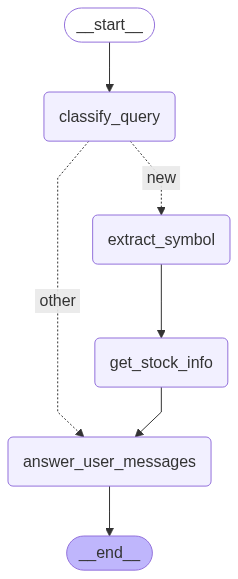

In [78]:
# View
display(Image(app.get_graph().draw_mermaid_png()))

In [79]:
# thread_id = "1"  # Unique identifier for user session
# config = {"configurable": {"thread_id": thread_id, "checkpointer": checkpointer}}

In [80]:
# # Test with a single stock messages
# messages = HumanMessage(input())
# result = app.invoke({"messages": messages}, config=config)
# print(result["response"].content)

In [81]:
# message = [HumanMessage(content='What is the value of ABB india today?', additional_kwargs={}, response_metadata={}, id='47d48867-a9a4-442b-9d69-21e5629f61e6'),
#            HumanMessage(content='Cool, what is the current P/E?', additional_kwargs={}, response_metadata={}, id='3a7b32f5-371b-45e9-acd6-a6dfbe6ea36c'),
#            HumanMessage(content='How much NTPC is trading for today?', additional_kwargs={}, response_metadata={}, id='92f935b3-a30e-4ee0-bf26-e2e8c3cac810')]

# message = [RemoveMessage(id=m.id) for m in message[:len(message)-1]]
# message

In [82]:
# Start conversation
# input_message = HumanMessage(content="hi!")
# for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
#     for m in event['messages']:
#         m.pretty_print()
#     print("---"*25)

In [83]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content=input())
async for event in app.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

 hi


Node: . Type: on_chain_start. Name: LangGraph
Node: classify_query. Type: on_chain_start. Name: classify_query
Node: classify_query. Type: on_chain_start. Name: RunnableSequence
Node: classify_query. Type: on_prompt_start. Name: ChatPromptTemplate
Node: classify_query. Type: on_prompt_end. Name: ChatPromptTemplate
Node: classify_query. Type: on_chat_model_start. Name: ChatGoogleGenerativeAI
Node: classify_query. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: classify_query. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: classify_query. Type: on_chat_model_end. Name: ChatGoogleGenerativeAI
Node: classify_query. Type: on_chain_end. Name: RunnableSequence
Node: classify_query. Type: on_chain_start. Name: route_query
Node: classify_query. Type: on_chain_end. Name: route_query
Node: classify_query. Type: on_chain_stream. Name: classify_query
Node: classify_query. Type: on_chain_end. Name: classify_query
Node: . Type: on_chain_stream. Name: LangGraph
Node: ans

In [84]:
# node_to_stream = 'answer_user_messages'
# config = {"configurable": {"thread_id": "4"}}
# input_message = HumanMessage(content="Hello")
# async for event in app.astream_events({"messages": [input_message]}, config, version="v2"):
#     # Get chat model tokens from a particular node 
#     if event["event"] in ["on_chat_model_stream", "on_chain_stream"] and event['metadata'].get('langgraph_node','') == node_to_stream:
#         print(event["data"])

In [85]:
# node_to_stream = 'answer_user_messages'
# config = {"configurable": {"thread_id": "4"}}
# input_message = HumanMessage(content="What is the value of NTPC today?")
# async for event in app.astream_events({"messages": [input_message]}, config, version="v2"):
#     # Get chat model tokens from a particular node 
#     if event["event"] in ["on_chat_model_stream", "on_chain_stream"] and event['metadata'].get('langgraph_node','') == node_to_stream:
#         print(event["data"])

In [90]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content=input())
async for event in app.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

 and P/E?


Based| on the provided data, the forward Price-to-Earnings (P/E) ratio| for NTPC Limited is 14.086759. There| is no trailing P/E ratio available.
|